In [1]:
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from PIL import Image

import pandas as pd
import numpy as np

# regression metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classification metrics
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

from ngboost import NGBRegressor, NGBClassifier
from ngboost.distns import Bernoulli

## Create combinatorial library

In [2]:
def mfs(s):
    return Chem.MolFromSmiles(s)

def mts(m):
    return Chem.MolToCXSmiles(m)

def sanitize_smiles(smi):
    m = Chem.MolFromSmiles(smi) 
    Chem.SanitizeMol(m)
    return Chem.MolToSmiles(m)

def sonogashira(smi_template, smi_alkyne):
    mol1 = Chem.MolFromSmiles(smi_template)
    mol2 = Chem.MolFromSmiles(smi_alkyne)
    smarts = "[#6:1]-[I,Br,Cl].[C:2]#[$([CH1]),$([#6X2][Si])]>>[*:1]C#[C:2]"
    rxn = AllChem.ReactionFromSmarts(smarts)
    reacts = (mol1, mol2)
    products = rxn.RunReactants(reacts) # tuple
    p = products[0][0]
    Chem.SanitizeMol(p)
    return p

In [3]:
df_templates = pd.read_csv('template_frags.csv').iloc[:10, :]
df_alkynes = pd.read_csv('alkyne_frags.csv').iloc[:27, :]

print('NUM TEMPLATE FRAGS : ', df_templates.shape[0])
print('NUM ALKYNE FRAGS : ', df_alkynes.shape[0])

NUM TEMPLATE FRAGS :  10
NUM ALKYNE FRAGS :  27


In [4]:
mols = []
templates_smi = []
alkynes_smi = []
templates_name = []
alkynes_name = []

for i_tem in df_templates.index:
    for i_alk in df_alkynes.index:
        smi_tem = df_templates.loc[i_tem, 'smiles']
        smi_alk = df_alkynes.loc[i_alk, 'smiles']
        
        name_tem = df_templates.loc[i_tem, 'name']
        name_alk = df_alkynes.loc[i_alk, 'name']
        
        # react
        p = sonogashira(smi_tem, smi_alk)
        
        # append info
        mols.append(p)
        templates_smi.append(sanitize_smiles(smi_tem))
        alkynes_smi.append(sanitize_smiles(smi_alk))
        templates_name.append(name_tem)
        alkynes_name.append(name_alk)

In [5]:
# generate dataframe including the reactant and product smiles
d = {'template_name':templates_name, 'alkyne_name':alkynes_name, 
     'template_smi':templates_smi, 'alkyne_smi':alkynes_smi, 
     'molecule_smi':[Chem.MolToSmiles(m) for m in mols]}
df = pd.DataFrame(d)
print(df.shape)
print(df.columns)
df.head()

(270, 5)
Index(['template_name', 'alkyne_name', 'template_smi', 'alkyne_smi',
       'molecule_smi'],
      dtype='object')


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...


In [6]:
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), maxMols=300)
png = img.data
with open('all_momlecules.png', 'wb+') as outf:
    outf.write(png)

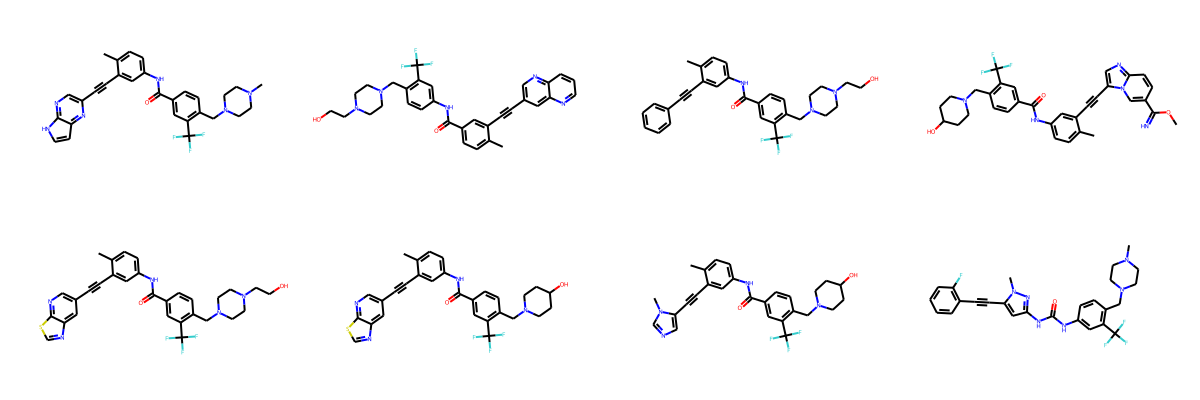

In [7]:
# check some molecules at random
Draw.MolsToGridImage(np.random.choice(mols, size=8), molsPerRow=4, subImgSize=(300, 200))

In [8]:
# load IC50s
df_results = pd.read_csv('exp_results.csv').iloc[:96, :]
df_results = df_results.rename(columns={'template':'template_name', 'alkyne':'alkyne_name'})
ic50 = df_results.loc[:, 'abl1_ic50_nM'].to_numpy()
# take log of IC50 values
df_results.loc[:, 'abl1_pIC50'] = - np.log10(ic50 * 10**(-9))
# combine the two dataframes
df_merged = df.merge(df_results, on=['template_name', 'alkyne_name'])
df_minimal = df_merged.drop(columns=['template_name', 'alkyne_name', 'template_smi', 'alkyne_smi', 
                        'synthesis_order', 'abl1_ic50_nM', 'abl2_ic50_nM'])
print(df_minimal.shape)
print(df_minimal.columns)
df_minimal.head()

(96, 3)
Index(['molecule_smi', 'synthesis_success', 'abl1_pIC50'], dtype='object')


,molecule_smi,synthesis_success,abl1_pIC50
0,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,8.045757
1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,no,NaN
2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,8.065502
3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,9.698970
4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,8.638272


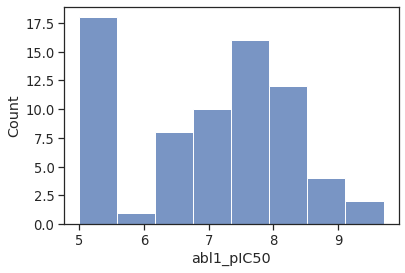

In [9]:
_ =sns.histplot(df_merged.loc[:, 'abl1_pIC50'])

In [10]:
df_regression = df_minimal.drop(columns=['synthesis_success'])
df_regression = df_regression.dropna()
#df_regression.to_csv('../chemprop/regression.csv', index=False)

df_classification = df_minimal.drop(columns=['abl1_pIC50'])
b = [0 if s=='no' else 1 for s in df_classification.loc[:, 'synthesis_success']]
df_classification.loc[:, 'synthesis_success'] = b

In [11]:
df_regression.shape, df_classification.shape
df_classification

,molecule_smi,synthesis_success
0,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1
1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0
2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1
3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1
4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1
...,...,...
91,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccc(F)cc4)n(C)n...,1
92,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cncnc4)n(C)n3)c...,1
93,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5nccn5c4)n(C...,0
94,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cncc5nc[nH]c45)...,1


## Build emulators - Regression

Emulators to try 

* GP on fingerprints (tanimoto kernel)
* GP on Mordred (RBF or Matern52)
* Deep kernel on FPs (warm up on ChemBL?)
* NGBoost on fingerprints


standard scale the targets, 10 fold cross-validation? optimizing the hyperparameters here?

Matteo's models achieving avg cross validation accuracy of RMSE=0.55+/-0.24, Pears=0.90+/-0.12 in predicting the pIC50 values

NGBoost with Morgan FPs seem to reduce the average RMSE over the 10 folds by about 38% to about RMSE=0.34+/-0.059

In [12]:
def featurize_regression(
        df, 
        features='ecfp',
        num_folds=10, 
        fold_size=8, 
        random_seed=100700, 
        make_holdout=False,
    ):
    ''' prepare the data for regression setting
    '''
    np.random.seed(random_seed)
    smiles = df.molecule_smi.tolist()
    y = df_regression.abl1_pIC50.values.reshape(-1, 1)
    print(np.isnan(np.sum(y)))
    mols = [mfs(s) for s in smiles]
    if features=='ecfp':
        X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=1024) for m in mols]).astype(np.float32)
    else:
        raise NotImplementedError
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    folds = []
    
    for fold_ix in range(num_folds):
        
        X_tr = X[indices[fold_size:], :]
        y_tr = y[indices[fold_size:], :]

        scaler = StandardScaler()
        scaler.fit(y_tr)
        y_tr = scaler.transform(y_tr)

        X_te = X[indices[:fold_size], :]
        y_te = y[indices[:fold_size], :]

        y_te = scaler.transform(y_te)

        folds.append({'X_tr':X_tr, 'y_tr':y_tr, 'X_te':X_te, 'y_te':y_te, 'scaler': scaler})

        indices = np.roll(indices, fold_size)

    return folds

def get_metrics_regression(true, pred):
    true, pred = true.ravel(), pred.ravel()
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred)
    pears = pearsonr(true, pred)[0]
    spear = spearmanr(true, pred)[0]
    return {'r2':r2, 'mae': mae, 'rmse': rmse, 'pears': pears, 'spear':spear}

def get_fold_metrics(metrics):
    fold_metrics={}
    for key in metrics[0].keys():
        key_metrics=[]
        for m in metrics:
            key_metrics.append(m[key])
        fold_metrics[f'{key}_mean'] = np.mean(key_metrics)
        fold_metrics[f'{key}_stderr'] = np.std(key_metrics) / np.sqrt(len(key_metrics))
    return fold_metrics
        

In [13]:
folds = featurize_regression(df_regression, random_seed=100700)

False


In [14]:
# train regression model on folds
fold_metrics_te = []
fold_metrics_tr = []

for fold in folds:
    X_tr, y_tr = fold['X_tr'], fold['y_tr']
    X_te, y_te = fold['X_te'], fold['y_te']
    
    model = NGBRegressor().fit(X_tr, y_tr)
    
    # train set prediction
    y_preds_tr = model.predict(X_tr)
    y_dists_tr = model.pred_dist(X_tr)
    samples_tr = y_dists_tr.sample(m=50).T
    y_std_tr = np.std(samples_tr, axis=-1)
    y_mu_tr = np.mean(samples_tr, axis=-1)
    
    # rescale the targets and predictions
    y_mu_tr = fold['scaler'].inverse_transform(y_mu_tr)
    y_tr = fold['scaler'].inverse_transform(y_tr)
    
    metrics_tr = get_metrics_regression(y_tr, y_mu_tr)
    fold_metrics_tr.append(metrics_tr)
    
    fold['y_tr_pred_mu'] = y_mu_tr.reshape(-1, 1)
    fold['y_tr_pred_std'] = y_std_tr.reshape(-1, 1)
    

    # test set prediction
    y_preds_te = model.predict(X_te)
    y_dists_te = model.pred_dist(X_te)
    samples_te = y_dists_te.sample(m=50).T
    y_std_te = np.std(samples_te, axis=-1)
    y_mu_te = np.mean(samples_te, axis=-1)
    
    y_mu_te = fold['scaler'].inverse_transform(y_mu_te)
    y_te = fold['scaler'].inverse_transform(y_te)
    
    metrics_te = get_metrics_regression(y_te, y_mu_te)
    
    fold_metrics_te.append(metrics_te)
    
    fold['y_te_pred_mu'] = y_mu_te.reshape(-1, 1)
    fold['y_te_pred_std'] = y_std_te.reshape(-1, 1)
    
    

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.5033 val_loss=0.0000 scale=2.0000 norm=1.0203
[iter 200] loss=-0.2928 val_loss=0.0000 scale=2.0000 norm=0.8715
[iter 300] loss=-0.9172 val_loss=0.0000 scale=2.0000 norm=0.7286
[iter 400] loss=-1.2379 val_loss=0.0000 scale=2.0000 norm=0.6449


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.6176 val_loss=0.0000 scale=2.0000 norm=1.0630
[iter 200] loss=-0.2137 val_loss=0.0000 scale=2.0000 norm=0.8831
[iter 300] loss=-0.9148 val_loss=0.0000 scale=2.0000 norm=0.7765
[iter 400] loss=-1.4663 val_loss=0.0000 scale=1.0000 norm=0.3524


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.4030 val_loss=0.0000 scale=2.0000 norm=1.0030
[iter 200] loss=-0.3872 val_loss=0.0000 scale=2.0000 norm=0.8656
[iter 300] loss=-1.0406 val_loss=0.0000 scale=2.0000 norm=0.7487
[iter 400] loss=-1.4375 val_loss=0.0000 scale=2.0000 norm=0.6515


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.5330 val_loss=0.0000 scale=2.0000 norm=1.0312
[iter 200] loss=-0.2518 val_loss=0.0000 scale=2.0000 norm=0.8705
[iter 300] loss=-0.8675 val_loss=0.0000 scale=1.0000 norm=0.3816
[iter 400] loss=-1.2657 val_loss=0.0000 scale=1.0000 norm=0.3515


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.4165 val_loss=0.0000 scale=2.0000 norm=0.9938
[iter 200] loss=-0.3664 val_loss=0.0000 scale=2.0000 norm=0.8587
[iter 300] loss=-0.9841 val_loss=0.0000 scale=1.0000 norm=0.3661
[iter 400] loss=-1.3915 val_loss=0.0000 scale=2.0000 norm=0.6977


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.4654 val_loss=0.0000 scale=2.0000 norm=1.0050
[iter 200] loss=-0.3193 val_loss=0.0000 scale=2.0000 norm=0.8636
[iter 300] loss=-0.9175 val_loss=0.0000 scale=2.0000 norm=0.7151
[iter 400] loss=-1.2596 val_loss=0.0000 scale=1.0000 norm=0.3269


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.4215 val_loss=0.0000 scale=2.0000 norm=1.0116
[iter 200] loss=-0.3394 val_loss=0.0000 scale=2.0000 norm=0.8567
[iter 300] loss=-0.9291 val_loss=0.0000 scale=2.0000 norm=0.7642
[iter 400] loss=-1.3599 val_loss=0.0000 scale=2.0000 norm=0.6762


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.5741 val_loss=0.0000 scale=2.0000 norm=1.0392
[iter 200] loss=-0.2377 val_loss=0.0000 scale=2.0000 norm=0.8706
[iter 300] loss=-0.8336 val_loss=0.0000 scale=2.0000 norm=0.7460
[iter 400] loss=-1.2367 val_loss=0.0000 scale=1.0000 norm=0.3491


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.5839 val_loss=0.0000 scale=2.0000 norm=1.0419
[iter 200] loss=-0.2053 val_loss=0.0000 scale=2.0000 norm=0.8796
[iter 300] loss=-0.8320 val_loss=0.0000 scale=2.0000 norm=0.7647
[iter 400] loss=-1.2571 val_loss=0.0000 scale=2.0000 norm=0.6536


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.4535 val_loss=0.0000 scale=2.0000 norm=1.0047
[iter 200] loss=-0.3507 val_loss=0.0000 scale=2.0000 norm=0.8829
[iter 300] loss=-1.0237 val_loss=0.0000 scale=1.0000 norm=0.3860
[iter 400] loss=-1.4021 val_loss=0.0000 scale=1.0000 norm=0.3188


In [15]:
fold_stats_tr = get_fold_metrics(fold_metrics_tr)
fold_stats_te = get_fold_metrics(fold_metrics_te)

In [16]:
fold_stats_te

{'r2_mean': 0.7723136672921402,
 'r2_stderr': 0.04086154861347534,
 'mae_mean': 0.37260859193945295,
 'mae_stderr': 0.02411388667913102,
 'rmse_mean': 0.33693835212033185,
 'rmse_stderr': 0.0601559682494432,
 'pears_mean': 0.9271253533823998,
 'pears_stderr': 0.010671209046062516,
 'spear_mean': 0.7698637058290648,
 'spear_stderr': 0.1003219630828174}

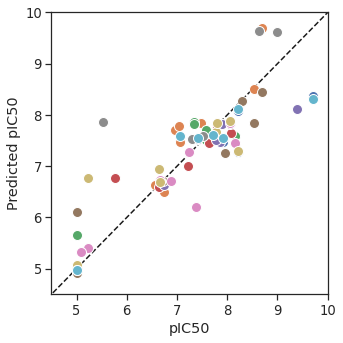

In [17]:
# plot the results
fig, ax = plt.subplots(figsize=(5,5))

for fold in folds:
    ax.scatter(fold['scaler'].inverse_transform(fold['y_te']), fold['y_te_pred_mu'], s=100, edgecolor='white')

ax.set_xlabel('pIC50')
ax.set_ylabel('Predicted pIC50')

ax.plot([1,100], [1,100], linestyle='--', color='k', zorder=0)

ax.set_xlim([4.5, 10])
ax.set_ylim([4.5, 10])

plt.tight_layout()
plt.savefig('ngboost_paitiry_plot.png', dpi=300)

In [18]:
# generate a training set with all available pIC50 measurements from Desai et al.
smiles = df_regression.molecule_smi.tolist()
y_tr = df_regression.abl1_pIC50.values.reshape(-1, 1)
mols = [mfs(s) for s in smiles]
X_tr = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=1024) for m in mols]).astype(np.float32)

scaler = StandardScaler()
scaler.fit(y_tr)
y_tr = scaler.transform(y_tr)

assert X_tr.shape[0]==y_tr.shape[0]==df_regression.shape[0]

In [19]:
# train the model on all available data
model_reg = NGBRegressor().fit(X_tr, y_tr)

# train set prediction
y_preds_reg = model.predict(X_tr)
y_dists_reg = model.pred_dist(X_tr)
samples_reg = y_dists_reg.sample(m=50).T
y_std_reg = np.std(samples_reg, axis=-1)
y_mu_reg = np.mean(samples_reg, axis=-1)

y_mu_reg = scaler.inverse_transform(y_mu_reg)
y_tr = scaler.inverse_transform(y_tr)

metrics_reg = get_metrics_regression(y_tr, y_mu_reg)

# fold['y_tr_pred_mu'] = y_mu_reg.reshape(-1, 1)
# fold['y_tr_pred_std'] = y_std_reg.reshape(-1, 1)

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000
[iter 100] loss=0.4885 val_loss=0.0000 scale=2.0000 norm=1.0174
[iter 200] loss=-0.2838 val_loss=0.0000 scale=2.0000 norm=0.8586
[iter 300] loss=-0.8677 val_loss=0.0000 scale=2.0000 norm=0.7368
[iter 400] loss=-1.2131 val_loss=0.0000 scale=2.0000 norm=0.6841


In [20]:
metrics_reg

{'r2': 0.9751278670497404,
 'mae': 0.09901277664349825,
 'rmse': 0.04256754848504885,
 'pears': 0.9875794056410628,
 'spear': 0.9809098282492201}

## Build emulators - Classification

Emulators to try 

* GP on fingerprints (tanimoto kernel)
* GP on Mordred (RBF or Matern52)
* Deep kernel on FPs (warm up on ChemBL?)
* NGBoost on fingerprints

Might want to do something like stratfied splitting for this bit? it is a bit of an unbalanced training set with 71 successful syntheses and 25 unsucessful

In [26]:
def featurize_classification(df, features='ecfp', num_folds=5, fold_size=20, random_seed=100700, make_holdout=False):
    ''' prepare the data for regression setting
    '''
    np.random.seed(random_seed)
    smiles = df.molecule_smi.tolist()
    y = df.synthesis_success.values.reshape(-1, 1)
    mols = [mfs(s) for s in smiles]
    if features=='ecfp':
        X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=1024) for m in mols]).astype(np.float32)
    else:
        raise NotImplementedError
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    folds = []
    
    for fold_ix in range(num_folds):
        
        X_tr = X[indices[fold_size:], :]
        y_tr = y[indices[fold_size:], :]
        
        X_te = X[indices[:fold_size], :]
        y_te = y[indices[:fold_size], :]
        
        folds.append({'X_tr':X_tr, 'y_tr':y_tr, 'X_te':X_te, 'y_te':y_te})
        
        indices = np.roll(indices, fold_size)

    return folds

def get_metrics_classification(true, pred_score, pred_label):
    true, pred_score = true.ravel(), pred_score.ravel()
    pred_label = pred_label.ravel()
    acc = accuracy_score(true, pred_label)
    roc_auc = roc_auc_score(true, pred_score)
    return {'acc': acc, 'roc_auc': roc_auc}

def get_fold_metrics(metrics):
    fold_metrics={}
    for key in metrics[0].keys():
        key_metrics=[]
        for m in metrics:
            key_metrics.append(m[key])
        fold_metrics[f'{key}_mean'] = np.mean(key_metrics)
        fold_metrics[f'{key}_stderr'] = np.std(key_metrics) / np.sqrt(len(key_metrics))
    return fold_metrics

In [27]:
folds_cla = featurize_classification(df_classification)

In [28]:
# train classifier on folds
fold_metrics_te = []
fold_metrics_tr = []

for fold in folds_cla:
    X_tr, y_tr = fold['X_tr'], fold['y_tr']
    X_te, y_te = fold['X_te'], fold['y_te']
    
    model = NGBClassifier(Dist=Bernoulli, verbose=False)
    _ = model.fit(X_tr, y_tr)
    
    # train set prediction
    y_tr_pred_prob = model.predict_proba(X_tr)[:, 1] # this returns each class probability
    y_tr_pred_label = model.predict(X_tr)
    
    
    metrics_tr = get_metrics_classification(y_tr, y_tr_pred_prob, y_tr_pred_label)
    fold_metrics_tr.append(metrics_tr)
    
    fold['y_tr_pred_prob'] = y_tr_pred_prob.reshape(-1, 1)
    fold['y_tr_pred_label'] = y_tr_pred_label.reshape(-1, 1)
    

    # test set prediction
    y_te_pred_prob = model.predict_proba(X_te)[:, 1]
    y_te_pred_label = model.predict(X_te)
    
    metrics_te = get_metrics_classification(y_te, y_te_pred_prob, y_te_pred_label)
    fold_metrics_te.append(metrics_te)
    
    fold['y_te_pred_prob'] = y_te_pred_prob.reshape(-1, 1)
    fold['y_te_pred_label'] = y_te_pred_label.reshape(-1, 1)

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

In [29]:
fold_stats_tr = get_fold_metrics(fold_metrics_tr)
fold_stats_te = get_fold_metrics(fold_metrics_te)

In [30]:
fold_stats_te

{'acc_mean': 0.78,
 'acc_stderr': 0.03633180424916991,
 'roc_auc_mean': 0.7094940476190477,
 'roc_auc_stderr': 0.027763785875172878}

In [116]:
# generate a training set with all available synthesis data from Desai et al.
folds_ = featurize_classification(df_classification, num_folds=1, fold_size=df_classification.shape[0])
X_tr, y_tr = folds_[0]['X_te'], folds_[0]['y_te']
assert X_tr.shape[0]==y_tr.shape[0]==df_classification.shape[0]
print(X_tr.shape, y_tr.shape)

(96, 1024) (96, 1)


In [117]:
# train the classification model on the full dataset

model_cla = NGBClassifier(Dist=Bernoulli, verbose=False)
_ = model_cla.fit(X_tr, y_tr)

 # train set prediction
y_cla_pred_prob = model_cla.predict_proba(X_tr)[:, 1] # this returns each class probability
y_cla_pred_label = model_cla.predict(X_tr)


metrics_cla = get_metrics_classification(y_tr, y_cla_pred_prob, y_cla_pred_label)

fold['y_tr_pred_prob'] = y_cla_pred_prob.reshape(-1, 1)
fold['y_tr_pred_label'] = y_cla_pred_label.reshape(-1, 1)


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [118]:
folds

{'acc': 0.9166666666666666, 'roc_auc': 0.9856338028169014}

## Use trained models to make prediction on unmeasured inhibitors

make predictions on the 270-(71+25) inhibitors for which we do not have measurements from Desai $\textit{et al.}$. These labels will then be taken as ground truth values for the subsequent constrained optimization experiments

### Classification 

In [132]:
# get the umeasured classification molecules
cla_smiles = df_classification.molecule_smi.tolist()
df_uncla = df[~(df.molecule_smi.isin(cla_smiles))]   # should be 270-96=174
print(df_uncla.shape)
df_uncla.head()

(174, 5)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...
7,8-1,22-8,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1ccccn1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
8,8-1,22-9,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnccn1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
9,8-1,22-10,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccc2n1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
10,8-1,22-11,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2[nH]ccc2n1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...


In [133]:
# make unmeasured classification features
smiles_uncla = df_uncla.molecule_smi.tolist()
mols_uncla = [mfs(s) for s in smiles_uncla]
X_uncla = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=1024) for m in mols_uncla]).astype(np.float32)
X_uncla.shape

(174, 1024)

In [138]:
# make predictions with trained model
y_uncla_pred_prob = model_cla.predict_proba(X_uncla)[:, 1] # this returns each class probability
y_uncla_pred_label = model_cla.predict(X_uncla)

In [148]:
df_pred_uncla = pd.DataFrame({
    'molecule_smi': cla_smiles+smiles_uncla,
    'synthesis_success': df_classification.synthesis_success.tolist()+y_uncla_pred_label.tolist(),
    'synthesis_success_prob': df_classification.synthesis_success.values.astype(np.float32).tolist()+y_uncla_pred_prob.tolist(),
    'is_experiment': [1 for _ in range(df_classification.shape[0])]+[0 for _ in range(y_uncla_pred_label.shape[0])]
    
})

In [149]:
print(df_pred_uncla.shape)
df_pred_uncla

(270, 4)


,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment
0,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1
1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1
2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1
3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1
4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1
...,...,...,...,...
265,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cccc(C#N)c4)n(C...,1,0.725197,0
266,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cccc(F)c4)n(C)n...,1,0.985571,0
267,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc(Nc5ccccc5)n...,1,0.805942,0
268,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccc(N)nc4)n(C)n...,1,0.985571,0


### Regression

In [192]:
# get the umeasured regression molecules
reg_smiles = df_regression.molecule_smi.tolist()
df_unreg = df[~(df.molecule_smi.isin(reg_smiles))]   # should be 270-71=199
print(df_unreg.shape)
df_unreg.head()

(199, 5)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
7,8-1,22-8,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1ccccn1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
8,8-1,22-9,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnccn1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
9,8-1,22-10,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccc2n1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...


In [193]:
# make unmeasured regression features
smiles_unreg = df_unreg.molecule_smi.tolist()
mols_unreg = [mfs(s) for s in smiles_unreg]
X_unreg = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=1024) for m in mols_unreg]).astype(np.float32)
X_unreg.shape

(199, 1024)

In [194]:
# make unmeasured regression predictions
y_preds_unreg = model_reg.predict(X_unreg)
y_dists_unreg = model_reg.pred_dist(X_unreg)
samples_unreg = y_dists_unreg.sample(m=50).T
y_std_unreg = np.std(samples_unreg, axis=-1)
y_mu_unreg = np.mean(samples_unreg, axis=-1)

# inverse transform the predictions
y_std_unreg = scaler.inverse_transform(y_std_unreg)
y_mu_unreg = scaler.inverse_transform(y_mu_unreg)

In [195]:
df_pred_unreg = pd.DataFrame({
    'molecule_smi': reg_smiles+smiles_unreg,
    'abl1_pIC50': df_regression['abl1_pIC50'].tolist()+y_mu_unreg.tolist(),
    'abl1_pIC50_std': [1 for _ in range(df_regression.shape[0])]+y_std_unreg.tolist(),
    'is_experiment': [1 for _ in range(df_regression.shape[0])]+[0 for _ in range(y_mu_unreg.shape[0])]
})
print(df_pred_unreg.shape)

(270, 4)


In [196]:
df_all = df_pred_uncla.merge(df_pred_unreg, how='outer', on='molecule_smi')
cols = [col for col in df_all.columns if col != 'is_experiment_y']
df_all = df_all[cols]
df_all

,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std
0,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000
1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1,7.515735,7.152991
2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000
3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000
4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.638272,1.000000
...,...,...,...,...,...,...
265,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cccc(C#N)c4)n(C...,1,0.725197,0,7.202788,7.053084
266,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cccc(F)c4)n(C)n...,1,0.985571,0,7.234019,7.051716
267,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc(Nc5ccccc5)n...,1,0.805942,0,7.762366,7.084657
268,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccc(N)nc4)n(C)n...,1,0.985571,0,7.493321,7.067724


In [197]:
# save the dataset to disk
df_all.to_csv('lookup_table.csv', index=False)

## Playground

In [99]:
prob = np.array([[0.1, 0.9], [0.51, 0.49]])

In [100]:
lab = np.argmax(prob, axis=1)
lab

array([1, 0])